The good way to understand how the neural network learns a time series pattern without the extra noise and complexity of real financial data to approximate sinusoid.

In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import os

2025-10-27 16:05:32.527346: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-27 16:05:32.650621: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-27 16:05:35.914991: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


Now the Data generation, the number of points and the number of cycles to generate a sine wave.

In [2]:
N_POINTS = 1500
N_CYCLES = 10

# The number of past time steps to use as input to predict the next time step.
SEQUENCE_LENGTH = 50
TRAIN_RATIO = 0.70
VALIDATION_RATIO = 0.15

In [3]:
RESULTS_DIR = "sinusoid_ffnn_model_res"
EPOCHS = 25
BATCH_SIZE = 32

Generating sinusiud data, remove(comment if need for future use) noise from previous code.

In [4]:
print("--- Generating Sinusoid Data ---")
# Create a time vector
time = np.linspace(0, N_CYCLES * 2 * np.pi, N_POINTS)
# Generate the sine wave
sin_wave = np.sin(time)

print(f"   Generated {N_POINTS} data points.")
# Return as a DataFrame
pd.DataFrame({'Value': sin_wave})

--- Generating Sinusoid Data ---
   Generated 1500 data points.


,Value
0,0.000000e+00
1,4.190357e-02
2,8.373353e-02
3,1.254164e-01
4,1.668790e-01
...,...
1495,-1.668790e-01
1496,-1.254164e-01
1497,-8.373353e-02
1498,-4.190357e-02


In [5]:
print("--- Preparing Data for FFNN ---")

# Prepare data
processed_data = sin_wave.reshape(-1, 1)

# Create sequences
X, y = [], []
for i in range(len(processed_data) - SEQUENCE_LENGTH - 100):
    X.append(processed_data[i:(i + SEQUENCE_LENGTH), 0])
    y.append(processed_data[i + SEQUENCE_LENGTH + 10, 0])
X, y = np.array(X), np.array(y)

# Define split sizes
total_samples = len(X)
train_size = 800
val_size = 200
test_size = 500

# Calculate actual available sizes
available_sizes = {
    'train': min(train_size, total_samples),
    'val': min(val_size, total_samples - train_size),
    'test': min(test_size, total_samples - train_size - val_size)
}

# Split data
X_train, y_train = X[:available_sizes['train']], y[:available_sizes['train']]
X_val, y_val = X[available_sizes['train']:available_sizes['train'] + available_sizes['val']], \
               y[available_sizes['train']:available_sizes['train'] + available_sizes['val']]
X_test, y_test = X[available_sizes['train'] + available_sizes['val']:available_sizes['train'] + available_sizes['val'] + available_sizes['test']], \
                 y[available_sizes['train'] + available_sizes['val']:available_sizes['train'] + available_sizes['val'] + available_sizes['test']]

print(f"   Training set size:   {len(X_train)} samples")
print(f"   Validation set size: {len(X_val)} samples")
print(f"   Test set size:       {len(X_test)} samples")

--- Preparing Data for FFNN ---
   Training set size:   800 samples
   Validation set size: 200 samples
   Test set size:       350 samples


In [13]:
print("--- Building, Training, and Evaluating Model ---")

model = Sequential([
  Input(shape=(SEQUENCE_LENGTH,)),
  Dense(64, activation='sigmoid'),
  Dense(1, activation='linear')
])
model.compile(optimizer='adam', loss='mse')
model.summary()

print("\n   Training the model...")
model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val), verbose=1)

print("\n   Evaluating model performance...")
loss = model.evaluate(X_test, y_test)
print(f"   Test loss: {loss:.4f}")
predictions_actual = model.predict(X_test)

y_test_actual = y_test.reshape(-1, 1)


print("\n   Evaluating model performance...")
mae = mean_absolute_error(y_test_actual, predictions_actual)
print(f"   Mean Absolute Error (MAE): {mae:.4f}")

--- Building, Training, and Evaluating Model ---


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,329 (13.00 KB)

 Trainable params: 3,329 (13.00 KB)

 Non-trainable params: 0 (0.00 B)


   Training the model...
Epoch 1/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.2947 - val_loss: 0.0086
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0078 - val_loss: 0.0035
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0011 - val_loss: 4.8421e-04
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.8906e-04 - val_loss: 1.9488e-04
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.7433e-04 - val_loss: 1.5401e-04
Epoch 6/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.4501e-04 - val_loss: 1.4065e-04
Epoch 7/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.2475e-04 - val_loss: 1.1567e-04
Epoch 8/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 1.0696e-04 - val_loss: 9.5898e-05
Epoch 9/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 8.9425e-05 - val_loss: 7.8129e-05
Epoch 10/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 7.2798e-05 - val_loss: 6.5498e-05
Epoch 11/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 6.0

....  Generating plot to visualize approximation...


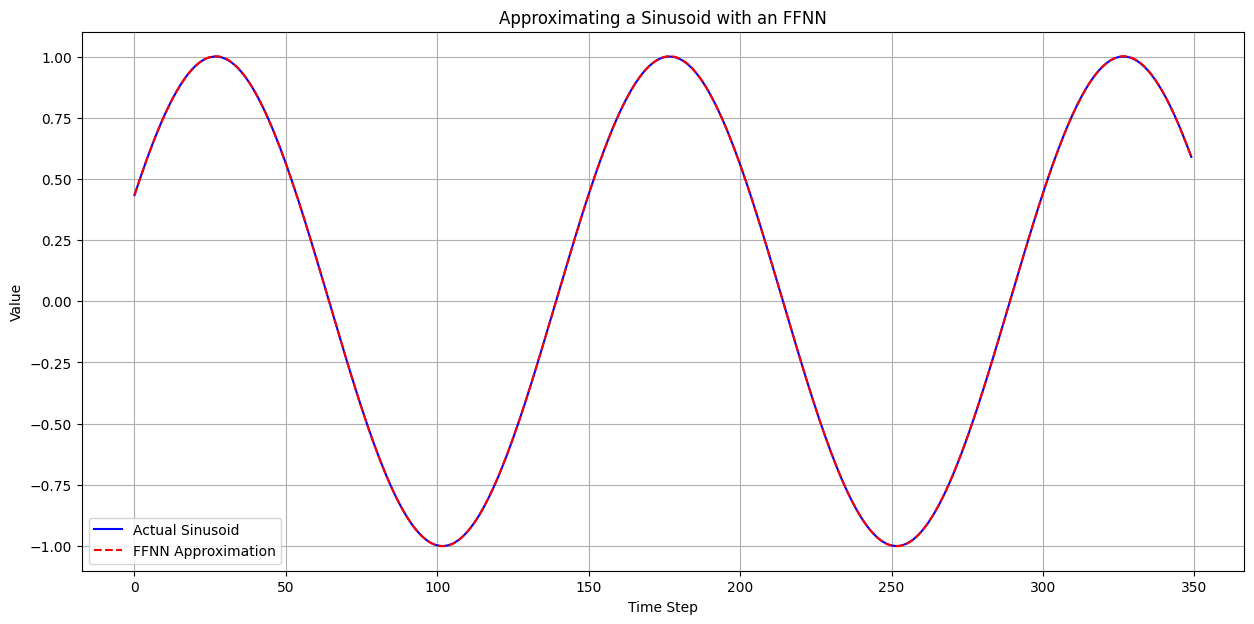

   Plot saved to 'sinusoid_ffnn_model_res/sinusoid_approximation.png'


In [7]:
print("....  Generating plot to visualize approximation...")
os.makedirs(RESULTS_DIR, exist_ok=True)
plot_path = os.path.join(RESULTS_DIR, 'sinusoid_approximation.png')

# Create an index for the x-axis of the plot
test_indices = np.arange(len(y_train) + len(y_val), len(y_train) + len(y_val) + len(y_test_actual))

plt.figure(figsize=(15, 7))
plt.plot(y_test_actual, color='blue', label='Actual Sinusoid')
plt.plot(predictions_actual, color='red', linestyle='--', label='FFNN Approximation')
plt.title('Approximating a Sinusoid with an FFNN')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.savefig(plot_path)
plt.show()
print(f"   Plot saved to '{plot_path}'")

In [8]:
print("First 5 data points of y_test_actual:")
display(y_test_actual[:5])

print("\nFirst 5 data points of predictions_actual:")
display(predictions_actual[:5])

First 5 data points of y_test_actual:


array([[0.43361397],
       [0.47099237],
       [0.50754338],
       [0.5432028 ],
       [0.57790799]])


First 5 data points of predictions_actual:


array([[0.43343425],
       [0.47077107],
       [0.50727206],
       [0.5428742 ],
       [0.5775166 ]], dtype=float32)

In [9]:
print(f"Number of data points used to calculate MAE: {len(y_test_actual)}")
print(f"Number of data points used to calculate MSE: {len(predictions_actual)}")

Number of data points used to calculate MAE: 350
Number of data points used to calculate MSE: 350


In [10]:
# Find indices where predictions_actual is close to 1
indices_at_1_pred = np.where(np.isclose(predictions_actual, 1, atol=0.05))[0] # Using a tolerance due to approximation
print("Timestep where predictions_actual is close to 1:", indices_at_1_pred)

# Find indices where predictions_actual is close to 0
indices_at_0_pred = np.where(np.isclose(predictions_actual, 0, atol=0.05))[0] # Using a tolerance due to approximation
print("Timestep where predictions_actual is close to 0:", indices_at_0_pred)

# Find indices where y_test_actual is close to 1
indices_at_1_actual = np.where(np.isclose(y_test_actual, 1, atol=0.05))[0] # Using a tolerance due to approximation
print("Timestep where y_test_actual is close to 1:", indices_at_1_actual)

# Find indices where y_test_actual is close to 0
indices_at_0_actual = np.where(np.isclose(y_test_actual, 0, atol=0.05))[0] # Using a tolerance due to approximation
print("Timestep where y_test_actual is close to 0:", indices_at_0_actual)


# Find the time step of the maximum value 1 in prediction_actual
index_of_max_actual = np.argmax(predictions_actual)
print(f"At {index_of_max_actual} timestep the max value close to 1 is {predictions_actual[index_of_max_actual]}")

Timestep where predictions_actual is close to 1: [ 20  21  22  23  24  25  26  27  28  29  30  31  32  33  34 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 320 321 322 323 324 325
 326 327 328 329 330 331 332 333 334]
Timestep where predictions_actual is close to 0: [ 64  65 139 140 213 214 215 288 289 290]
Timestep where y_test_actual is close to 1: [ 20  21  22  23  24  25  26  27  28  29  30  31  32  33  34 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 319 320 321 322 323 324
 325 326 327 328 329 330 331 332 333 334]
Timestep where y_test_actual is close to 0: [ 64  65 139 140 213 214 215 288 289 290]
At 27 timestep the max value close to 1 is [1.0012659]


In [11]:
zero_values = predictions_actual[indices_at_0_pred]

# Find the index within zero_values that is closest to 0
closest_to_zero_index_in_list = np.argmin(np.abs(zero_values))

# Get the actual index from the original zero_indices list
closest_to_zero_timestep = indices_at_0_pred[closest_to_zero_index_in_list]
print(f"At {closest_to_zero_timestep} timestep the value close to 0 is {predictions_actual[closest_to_zero_timestep]}")

At 289 timestep the value close to 0 is [-0.0042854]
